In [5]:
import numpy as np
import scipy.sparse as sp

import bz2
import pickle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.colors as colors

import sys
sys.path.append('../similarity')
from simMat import *

cmap = cm.get_cmap("jet")

# Load matches file

mf = bz2.BZ2File("../Data/matches_pickle.bin")
Matches = pickle.load(mf)

# Load Rs
Rs = sp.load_npz("../Data/Rs_sparse.npz")

# Load element list
elemList = getElemList('../Data/')

In [6]:
len(Matches), Rs.shape

(8867083, (8867083, 104))

In [63]:
def count_C_in_R(elem,yspan,orggen=False,v=0):
    """
    Count compounds for element `elem`, for every year in `yspan`,
    distinguishing by either contain C or not.
    If orggen==True: Count C + other organogenic elements.
    v: set verbosity. 0 means print nothing
    """
    
    # Query matches
    mats_q = []
    rs_q = []
    yrs_q = []

    for i, M in enumerate(Matches):
        if elem in M[0]:
            y = int(M[1][M[0].index(elem)])
            if y>=yspan[0] and y<=yspan[1]:
                mats_q.append(M)
                rs_q.append(Rs[i].toarray().flatten())
                yrs_q.append(y)

    if len(mats_q)==0:
        return None
    if v>0:   print(len(mats_q))

    
    rs_q_arr = np.array(rs_q)
    yrs_arr = np.array(yrs_q)

    ###### Exclude compounds where sum(R)==100 
    # These are alloys where count atoms sums up to 100
    indx = rs_q_arr.sum(axis=1)!=100
    yrs_arr100 = yrs_arr[indx]
    rs_q_arr100 = rs_q_arr[indx]
    ######

    df1 = pd.DataFrame(index=["OM","TOT"],
                       columns=range(yspan[0],yspan[1]+1))

    ####### Filter orgmet
    organogenic = ["N","O","F","Cl","Br","P","S"]

    if orggen:
        sm = np.zeros(rs_q_arr.shape[0])
        for i in organogenic:
            sm += rs_q_arr[:,elemList.index(i)]>0
        
    indx_om =   indx * (rs_q_arr[:,5]>0) # Contain C
    if orggen:  indx_om *= (sm>0)   #  AND some organogenic
    indx_noom = indx * (rs_q_arr[:,5]==0)   # Contains no C


    mats_q_om = {}
    mats_q_noom = {}
    for y in range(yspan[0],yspan[1]+1):
        yrs = yrs_arr == y
        
        
        ################
        # Get C in R
        indx_y = indx_om * yrs
        
        #### Fill dict with Ms that pass the filters
        mats_q_om[y] = []
        for i,M in enumerate(mats_q):
            if indx_y[i]:
                mats_q_om[y].append(M)
        
        # Rs that contain C AND some element in list `organogenic`
        df1.loc["OM",y] = rs_q_arr[indx_y].shape[0] 
        
        ################
        # Get C not in R
        indx_y = indx_noom * yrs
        
        #### Fill dict with Ms that pass the filters
        mats_q_noom[y] = []
        for i,M in enumerate(mats_q):
            if indx_y[i]:
                mats_q_om[y].append(M)
        
        # Rs that don't contain C
        df1.loc["noOM",y] = rs_q_arr[indx_y].shape[0]
        
        ################        
        # Total compounds of this elem
        df1.loc["TOT",y] = rs_q_arr[yrs].shape[0]

    if v>0:  print(df.head())
    return df1, mats_q_om, mats_q_noom


def countCR_list(elems,yspan,orggen=False,v=0):

    df = pd.DataFrame()

    for elem in elems:
        df1=count_C_in_R(elem, yspan, orggen, v)
        if df1 is not None:
            df1 = df1[0]
        else:
            continue
        df1["elem"]=elem
        df = pd.concat([df,df1],axis=0)

    ind = pd.MultiIndex.from_arrays([df.elem, df.index])
    df = (df
          .set_index(ind)
          .drop(columns=["elem"])
          .astype(float))
    return df


def lineplotCR(df, save=False, fh=1.7):
    elems = df.index.levels[0]
    fig,ax = plt.subplots(len(elems),figsize=(15,fh*len(elems)),
                          gridspec_kw={"hspace":0.1}, 
                          sharex=True)

    for i,m in enumerate(elems):

        ax[i].plot(df.loc[m].loc["OM"] , "k--")
        ax[i].plot(df.loc[m].loc["noOM"] , "r-")


        custom_lines = [Line2D([0], [0], color='w', lw=0),
                        Line2D([0], [0], color='k', lw=4,ls="--"),
                        Line2D([0], [0], color='r', lw=4)]

        ax[i].legend(custom_lines, 
                     [m,'C in R', 'C not in R'], 
                     fontsize=10,
                     loc=2)

        ax[i].grid(axis="x")

    if save:
        plt.savefig(save, dpi=300, bbox_inches="tight")
    plt.show()

    
from matplotlib.ticker import (MultipleLocator, FixedLocator)
def heatplotCR(df, ax, cbar, save=False,CinR=True,fh=10, label="", top_ax=True):   


    ax.tick_params(labelbottom=True,labeltop=top_ax)
    ax.xaxis.set_ticks_position("both")
    
    if CinR: labl="OM"
    else:    labl="noOM"
        
    om = (df
          .loc[(slice(None),labl),:]
          .droplevel(1))

    om = om.div(om.max(axis=1),axis=0)
    
    sns.heatmap(om, 
                cmap=cmap, 
                cbar_ax = cbar,
                ax=ax,
               norm=colors.PowerNorm(gamma=0.8));
    ax.set_ylabel("")

    
    if label:
        cbar.yaxis.set_ticks_position('right')
        cbar.yaxis.set_label_position("left")
        cbar.set_ylabel(label, fontsize=24)

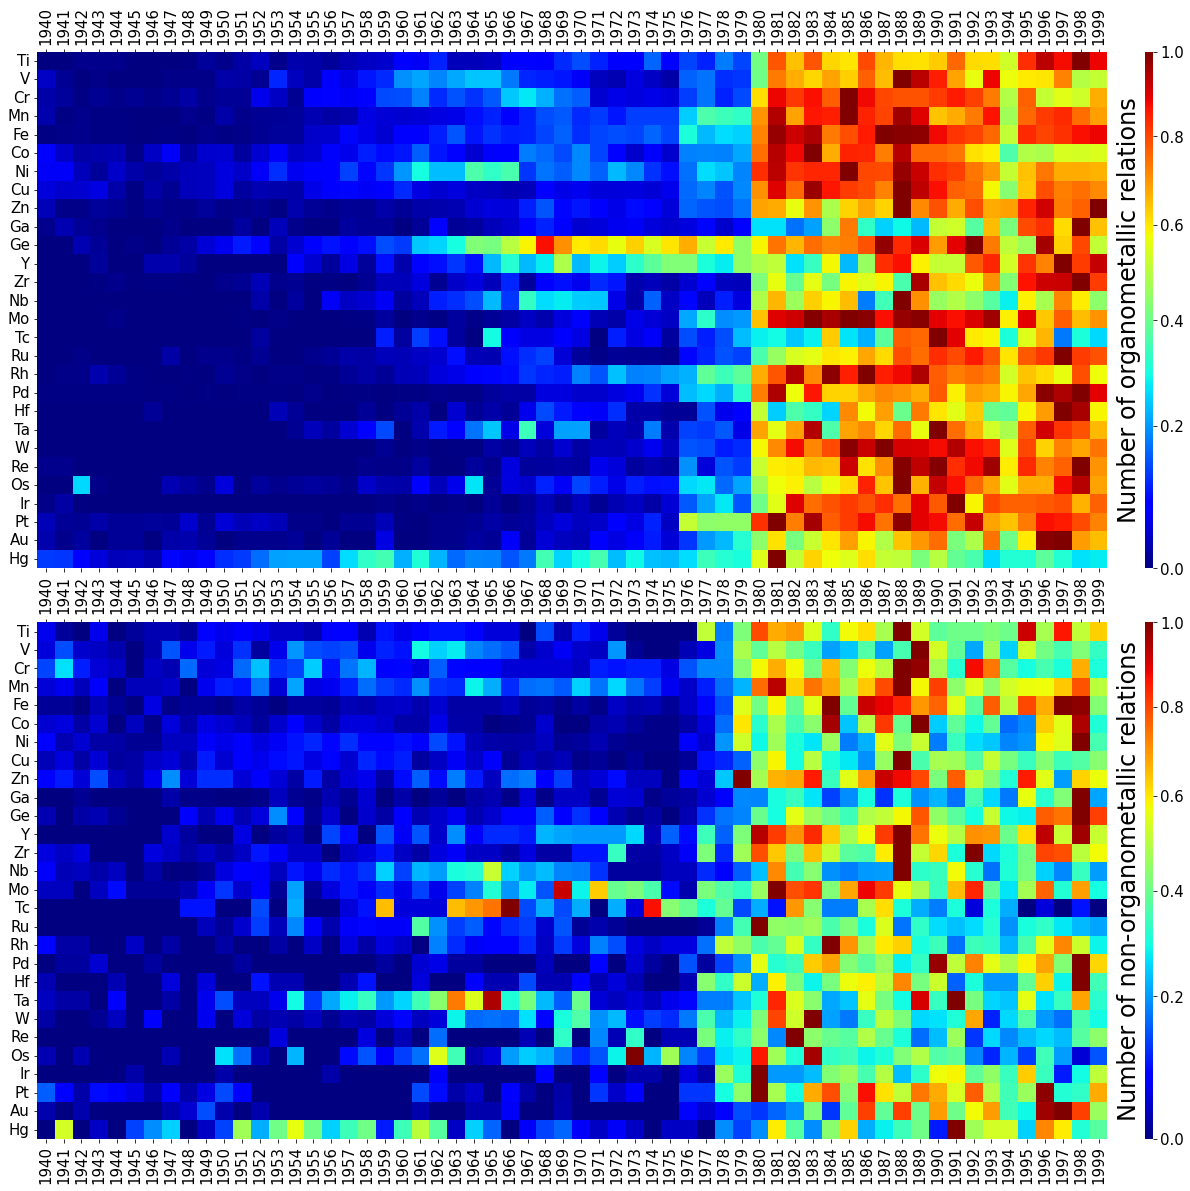

In [68]:
metals = [i for i in range(21,32)]
metals += [i for i in range(38,46)]
metals += [i for i in range(71,80)]

metals = [elemList[i] for i in metals]

df=countCR_list(metals,
                yspan=(1940,1999),
                orggen=False,v=0)


plt.rcParams["font.size"]= 15
fig,ax = plt.subplots(2,2,
                      figsize=(20,20),
                      gridspec_kw={"width_ratios":[140,1],
                                   "wspace":0.07, 
                                   "hspace":0.1051})

heatplotCR(df, ax[0,0], ax[0,1],
           CinR=True, 
           label = "Number of organometallic relations")

heatplotCR(df, ax[1,0], ax[1,1],
           CinR=False, 
           label = "Number of non-organometallic relations", 
           top_ax=False)

plt.savefig("orgmet.png",dpi=300, bbox_inches="tight")

# From this analysis, we can classify metal-relating compounds in 3:

- Organometallic
        - These seem to be very popular before 1980 but in this year there is a drop
- Alloys
        - Usually reported as having 100 atoms
- New materials
        - Combinations of metals with other metals, non-metals, etc.
        - Usually synthesyzed and published as AxR, with A=metal, explicitly joining our elements.
        - Example stoichiometries are AxMo6S6O2, Gd2Ni17-xAlx, Ho2Ni12P7
        
        
---

# Same analysis for B, F, P, etc. Elements that are also seen to increase around 1980.

NameError: name 'Line2D' is not defined

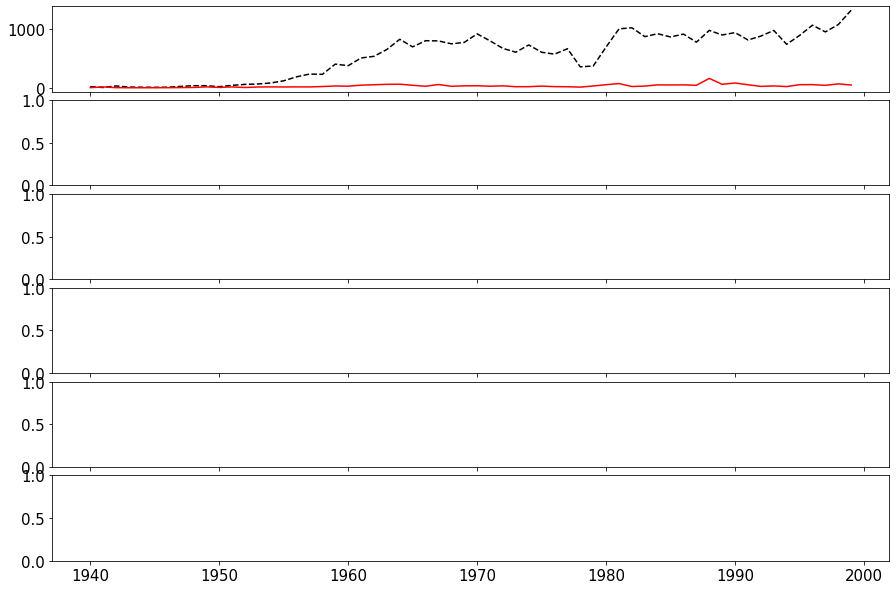

In [69]:
elems = ["B","F","P","Si","Sc","Ge"]

df=countCR_list(elems,
                yspan=(1940,1999),
                orggen=False,v=0)

lineplotCR(df, save="BFPSi_C.png")

# Lanthanoids

In [ ]:
lant = [i for i in range(56,70)]
lant = [elemList[i] for i in lant]

df=countCR_list(lant,
                yspan=(1940,1999),
                orggen=False,v=0)

lineplotCR(df, save="Lanthanoids_C.png")

In [ ]:
actin = [i for i in range(88,102)]
actin = [elemList[i] for i in actin]


df=countCR_list(actin,
                yspan=(1940,1999),
                orggen=False,v=0)

lineplotCR(df, save="Actinoids_C.png")

---

# Explore what substances are responsible for similarities between pairs of elements.

In [1460]:
def filterMatch(elem, yspan, pair_elems):
    
    # Get all matches that contain `elem`
    mats_q = []

    for i, M in enumerate(Matches):
        if elem in M[0]:
            y = int(M[1][M[0].index(elem)])
            if y>=yspan[0] and y<=yspan[1]:
                mats_q.append(M)
                
    # Get all matches that contain elem AND some of pair_elems
    list_q={}
    for e in pair_elems:
        subs_m=[]
        for i, M in enumerate(mats_q):
            if e in M[0]:
                y = int(M[1][M[0].index(e)])  # Year for this elem in this Rn
                if y>=yspan[0] and y<=yspan[1]:
                    subs_m.append(M)
        list_q[e]=subs_m
                    
    return mats_q, list_q

def printListHierarch(matches,nmax=20):
    for i in range(2,nmax):
        l = [m for m in matches if len(m[0])==i]
        if len(l)>0:
            print(i)
            [print(m) for m in matches if len(m[0])==i]
            print()


# Check H. We want to see in particular why the change happened, from the alkalines in 1854 to the halogens in 1866.

In [1477]:
elem="H"
yspan=(1800,1890)
pair_elems = ["Na","K","Ag","Li","Br","Cl","F","I","C","O","S","N"]

mats_q, subs_m = filterMatch(elem, yspan, pair_elems)
len(mats_q)

84135

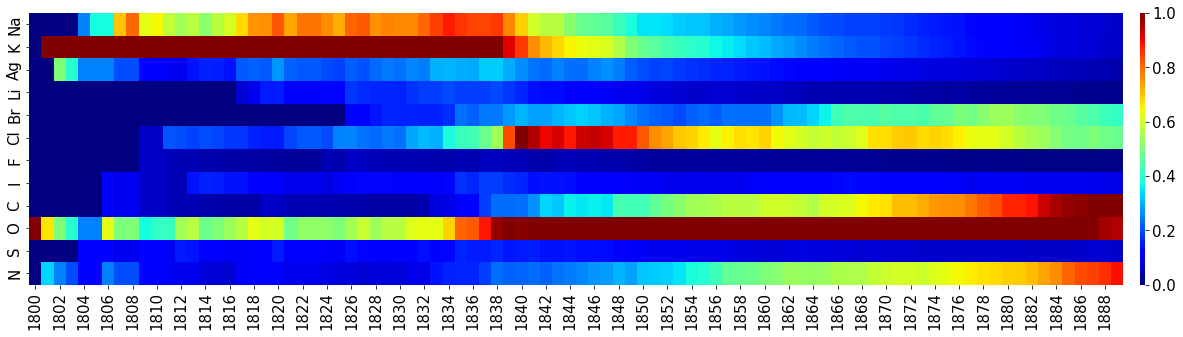

In [1478]:
df = pd.DataFrame(columns=elems,index=range(*yspan))

for e in pair_elems:
    subs_m_e = subs_m[e]

    d = [max(
            [int(M[1][M[0].index(elem)]),
            int(M[1][M[0].index(e)])]
            ) for M in subs_m_e]
        
    df[e]=(pd.Series(d)
              .value_counts()
             )
df = (df
      .fillna(0)
      .astype(int)
     )

fig,ax=plt.subplots(1,2,
                    figsize=(20,5),
                    gridspec_kw={"width_ratios":[200,1],
                                 "wspace":0.03})

mapa = df.sort_index(ascending=True).cumsum().T
mapa = mapa/mapa.max(axis=0)

sns.heatmap(mapa, cmap=cmap, ax=ax[0], cbar_ax=ax[1]);

### These results show that before 1839, H was mostly close to K (and Na but much less). After this year, relations found increase with Cl and O. Let's analyze these 3 elements.

In [1449]:
subs_m['K'], subs_m['Cl'], subs_m['O']

## Inspecting these lists, we see that:

- H - K is due mostly to salts.
- H - Cl is due mostly to substitution in organic compounds.
- H - O has also organic chemistry as the main source.

### Visually inspecting we see that can happen in a given organic molecule with at least 2 Oxygens: 1 sp3 and 1 sp2. Like reduction from an esther to an alkane, or carbonyl + alcohol to alkane. 

We test this hypothesis by checking that: Rs are mainly composed of CHO, and n is mostly even.

In [1479]:
elems=("H","O")
yspan=(1800,1880)

# Query matches
mats_q = []

for i, M in enumerate(Matches):
    if elems[0] in M[0] and elems[1] in M[0]:
        y1,y2 = int(M[1][M[0].index(elems[0])]), int(M[1][M[0].index(elems[1])])
        if y1>yspan[0] and y1<yspan[1] and y2>yspan[0] and y2<yspan[1]:
            mats_q.append(Rs[i])

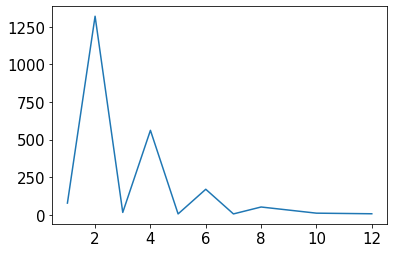

In [1480]:
# Check the distribution of ns

ff = np.array([i.toarray().flatten() for i in mats_q])
x,y=np.unique(ff[:,-1],return_counts=True)
plt.plot(x,y)

In [1481]:
# Check how many times each element appears in some R
# Ordered by Z: C, N, O are 6,7,8.

(np.array([i.toarray().flatten() for i in mats_q]) != 0).sum(axis=0)

array([2116,    0,    5,    1,    1, 2081, 1010, 1397,    1,    0,   19,
          2,    3,    7,   14,  231,  198,    0,   11,    7,    0,    1,
          0,    7,    4,    3,    5,    2,   11,    6,    0,    0,    4,
          3,  192,    0,    1,    5,    0,    1,    0,    2,    0,    0,
          0,    2,    3,    6,    0,    1,    4,    3,   30,    0,    0,
          7,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    2,    0,    2,    1,
         21,    0,    8,    4,    6,    1,    0,    0,    0,    0,    0,
          0,    1,    0,    3,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 2219])

---

# Fluorine

### Before 1958, we see that similarities between Cl,Br,I were strong with N,H and F, but F with N,H were not.

On top of that, N,H were also similar to C,O,S, so this region looks like 3 superimposed squares, hard to detect for algorithm.

Around 1950-58, similarities F to N,H strengthen, increasing the contrast.

Thus, this huge family separates because of F. Let's check what chemistry!

In [1482]:
elem="F"
yspan=(1940,1970)
pair_elems = ["N","H","F"]

mats_q, subs_m = filterMatch(elem, yspan, pair_elems)
len(mats_q)

97831

(-50.0, 300.0)

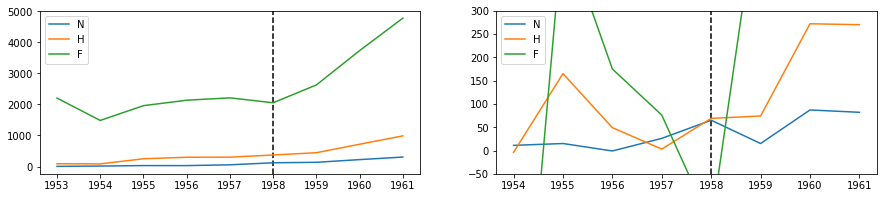

In [260]:
elems = ["N","H","F"]
df = pd.DataFrame(columns=elems,index=range(*yspan))

for elem in elems:
    subs_m=[]
    for i, M in enumerate(mats_q):
        if elem in M[0]:
            y = int(M[1][M[0].index(elem)])  # Year for this elem in this Rn
            if y>=yspan[0] and y<=yspan[1]:
                subs_m.append(M)
         
    d = []
    for m in subs_m:
        d.append(
            max(
                int(m[1][m[0].index("F")]),
                int(m[1][m[0].index(elem)])
            ))
        
    df[elem]=(pd.Series(d)
              .value_counts()
             )
df = (df
      .fillna(0)
      .astype(int)
     )

fig,ax=plt.subplots(1,2,figsize=(15,3))


ax[0].axvline(1958,color='k',linestyle='--')
ax[1].axvline(1958,color='k',linestyle='--')


# Plot the number
df.plot(ax=ax[0])

# Plot the derivative
df.diff().plot(ax=ax[1])
ax[1].set_ylim(-50,300)

In [256]:
df

,N,H,F
1953,4,88,2200
1954,15,84,1482
1955,30,249,1957
1956,29,298,2132
1957,55,301,2208
1958,120,370,2050
1959,135,444,2624
1960,222,716,3728
1961,304,986,4772


## Both of them increase significantly around 1956. 

### Let's see why by looking at narrower timespan

In [1462]:
elem="F"
yspan=(1953,1962)
pair_elems = ["N","H","F"]
mats_q, subs_m = filterMatch(elem, yspan, pair_elems)
len(mats_q)

#printListHierarch(subs_m["N"],nmax=20)

28941

### Looking at these substances, we see that

- F - H is pretty much the just the commmon substitution pattern among halogens.
- F - N is more interesting, and corresponds to substitution on molecules containing high amounts of N(sp2) and some N(sp3). 

Checking them, we observe a lot of heterocyclic chemistry (from the N side), when replaced by F is transformed into fluorated alkane chemistry in lots of cases.

All this are reductions of the N(sp2).

A similar argument explains similarity between N and the other halogens.

## How to easily count N heterocycles???

---

# Noble gases

In [1466]:
elem="Kr"
yspan=(1900,1965)
pair_elems = ["Ne", "Ar", "Xe"]
mats_q, subs_m = filterMatch(elem, yspan, pair_elems)
len(mats_q)

#printListHierarch(subs_m["Xe"],nmax=20)

15

# Analogous compounds involving Kr and Xe were reported in 1940, but the same analogous comp. was also found for:

['W', 'S', 'Fe', 'Si', 'Ni', 'O', 'Se', 'Xe', 'Hg', 'Cr', 'Te', 'C', 'Mo', 'Kr', 'N', 'P', 'H'].

So maybe family formation in the 1950s (Kr, Xe) was triggered by a differentiation of the actinoids. So: before this year, all elements with little data were a dark region (noble gases + actinoids) but after war actinoid chemistry starts being explored, differenetiating the two families, i.e. the pair Kr, Xe was left alone, with a single datapoint joining them.


# This paper published in 1960 produces some compounds involving noble gases Ar, Kr, Xe.

WALLER, J. New Clathrate Compounds of the Inert Gases. Nature 186, 429–431 (1960). https://doi.org/10.1038/186429a0

This is responsible for joining of Ar, and strengthens Kr-Xe.

# Then in 1964 they publish this

A Krypton Difluoride-Antimony Pentafluoride Complex. Selig, Henry. Peacock, Raymond D. doi: 10.1021/ja01072a075. Journal of the American Chemical Society. https://doi.org/10.1021/ja01072a075

First compound of Kr (then someone else makes an analogous with Xe).

In [1471]:
elem="Ar"
yspan=(1900,2000)
pair_elems = ["Ne", "Kr", "Xe"]
mats_q, subs_m = filterMatch(elem, yspan, pair_elems)
print(len(mats_q))

#printListHierarch(subs_m["Ne"],nmax=20)

263


# Ne joins the noble gases in 1997, mainly through sim with Ar.

With works like  

Yunjie Xu and Wolfgang Jäger, "High resolution spectroscopy of Ne and Ar containing noble gas clusters", J. Chem. Phys. 107, 4788-4796 (1997) https://doi.org/10.1063/1.474842 

Explained by noble gas clusters.

# Ge

In [1475]:
elem="Ge"
yspan=(1925,1935)
pair_elems = ["Si", "Sn"]
mats_q, subs_m = filterMatch(elem, yspan, pair_elems)
print(len(mats_q))

#printListHierarch(subs_m["Sn"],nmax=20)

210


# Ga

In [1476]:
elem="In"
yspan=(1925,1935)
pair_elems = ["Ga", "Al"]
mats_q, subs_m = filterMatch(elem, yspan, pair_elems)
print(len(mats_q))

#printListHierarch(subs_m["Al"],nmax=20)

37
